In [402]:
import os
from IPython.display import display, clear_output
from xgboost import XGBRegressor
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.decomposition import PCA

from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import random
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels.api as sm
plt.style.use('ggplot')
pd.options.display.float_format = '{:.4f}'.format

os.chdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA')
os.getcwd()

'/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA'

In [403]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Свердловская_область.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

In [404]:
ardl_df = pd.DataFrame()

res = ARDL(
    y_train,
    2,
    X_train,
    2,
    trend='n'
).fit()
ardl_df = pd.concat([res.params, res.pvalues], axis=1)
ardl_df.columns = ['coef', 'p-value']
ardl_df.drop(['p-value', 'coef'], axis=1, inplace=True)
ardl_df_inner = ardl_df.copy()
ardl_df_left = ardl_df.copy()

## ARDL


In [405]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir('/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')

def add_stars(row):
    coef = row['coef']
    pval = row['p-value']
    if pval < 0.01:
        return f"{coef:.2f}***"
    elif pval < 0.05:
        return f"{coef:.2f}**"
    elif pval < 0.1:
        return f"{coef:.2f}*"
    else:
        return f"{coef:.2f}"


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                 'outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                'outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
    df_result_region = pd.concat([res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]

    res = ARDL(
        y_train,
        2,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = ['coef', 'p-value']
    result[f'{file_name[5:-4]}'] = result.apply(add_stars, axis=1)
    result.drop(['p-value', 'coef'], axis=1, inplace=True)
    ardl_df_left = pd.merge(ardl_df_left, result,left_index=True, right_index=True, how='left')
    ardl_df_inner = pd.merge(ardl_df_inner, result,left_index=True, right_index=True, how='inner')

ardl_df_left

100%|██████████| 78/78 [00:01<00:00, 58.75it/s]


Алтайский_край Волгоградская_область  \
inflation.L1                                0.22*               0.55***   
inflation.L2                              0.25***               0.46***   
Brent.L0                                     0.01                 -0.01   
Brent.L1                                      NaN                   NaN   
Brent.L2                                      NaN                   NaN   
MIACR.L0                                  0.54***               0.56***   
MIACR.L1                                 -0.51***              -0.57***   
MIACR.L2                                      NaN                   NaN   
obligates.L0                               -0.12*                -0.14*   
obligates.L1                                  NaN                   NaN   
obligates.L2                                  NaN                   NaN   
M2.L0                                        8.94                 -3.74   
M2.L1                                         NaN                   NaN   
M2.L2                                         NaN                   NaN   
money_income.L0                              0.15               8.74***   
money_income.L1                               NaN                   NaN   
money_income.L2                               NaN                   NaN   
trade_turnover.L0                         3.35***                  0.03   
trade_turnover.L1                             NaN                   NaN   
trade_turnover.L2                             NaN                   NaN   
debt_firms.L0                                2.37                  2.65   
debt_firms.L1                                5.01                   NaN   
debt_firms.L2                             -7.69**                   NaN   
Компонента рыночной конъюнктуры.L0        -0.04**              -0.06***   
Компонента рыночной конъюнктуры.L1            NaN                 -0.02   
Компонента рыночной конъюнктуры.L2            NaN                  0.03   
Компонента предложения.L0                    0.03                -0.11*   
Компонента предложения.L1                     NaN                   NaN   
Компонента предложения.L2                     NaN                   NaN   
Компонента денежного рынка.L0                0.01                 -0.04   
Компонента денежного рынка.L1                 NaN                   NaN   
Компонента денежного рынка.L2                 NaN                   NaN   
Компонента ожидания.L0                      0.08*                  0.02   
Компонента ожидания.L1                        NaN                   NaN   
Компонента ожидания.L2                        NaN                   NaN   
Компонента валютного канала.L0               0.06               0.15***   
Компонента валютного канала.L1                NaN                   NaN   
Компонента валютного канала.L2                NaN                   NaN   
Компонента спроса.L0                         0.02                 -0.03   
Компонента спроса.L1                          NaN                   NaN   
Компонента спроса.L2                          NaN                   NaN   
outlier_12.L0                              1.22**                  0.56   
outlier_12.L1                                 NaN              -2.71***   
outlier_12.L2                                 NaN                   NaN   
outlier_98.L0                              2.40**                 -1.36   
outlier_98.L1                                 NaN              -2.52***   
outlier_98.L2                                 NaN                   NaN   

                                   Амурская_область  \
inflation.L1                                0.78***   
inflation.L2                                  0.22*   
Brent.L0                                      -0.00   
Brent.L1                                        NaN   
Brent.L2                                        NaN   
MIACR.L0                                    0.48***   
MIACR.L1                                   -0.49*

In [406]:
ardl_df_inner

Алтайский_край Волгоградская_область  \
inflation.L1                                0.22*               0.55***   
inflation.L2                              0.25***               0.46***   
Brent.L0                                     0.01                 -0.01   
MIACR.L0                                  0.54***               0.56***   
obligates.L0                               -0.12*                -0.14*   
M2.L0                                        8.94                 -3.74   
money_income.L0                              0.15               8.74***   
trade_turnover.L0                         3.35***                  0.03   
debt_firms.L0                                2.37                  2.65   
Компонента рыночной конъюнктуры.L0        -0.04**              -0.06***   
Компонента предложения.L0                    0.03                -0.11*   
Компонента денежного рынка.L0                0.01                 -0.04   
Компонента ожидания.L0                      0.08*                  0.02   
Компонента валютного канала.L0               0.06               0.15***   
Компонента спроса.L0                         0.02                 -0.03   
outlier_12.L0                              1.22**                  0.56   
outlier_98.L0                              2.40**                 -1.36   

                                   Амурская_область  \
inflation.L1                                0.78***   
inflation.L2                                  0.22*   
Brent.L0                                      -0.00   
MIACR.L0                                    0.48***   
obligates.L0                               -0.20***   
M2.L0                                          5.66   
money_income.L0                               -0.21   
trade_turnover.L0                              0.73   
debt_firms.L0                                 -1.23   
Компонента рыночной конъюнктуры.L0          -0.05**   
Компонента предложения.L0                      0.02   
Компонента денежного рынка.L0               -0.07**   
Компонента ожидания.L0                        -0.04   
Компонента валютного канала.L0               0.08**   
Компонента спроса.L0                          -0.04   
outlier_12.L0                                 -0.46   
outlier_98.L0                              -2.86***   

                                   Еврейская_автономная_область  \
inflation.L1                                            0.82***   
inflation.L2                                            0.18***   
Brent.L0                                                 0.02**   
MIACR.L0                                                0.60***   
obligates.L0                                              -0.07   
M2.L0                                                   14.97**   
money_income.L0                                            0.18   
trade_turnover.L0                                          0.74   
debt_firms.L0                                             -0.91   
Компонента рыночной конъюнктуры.L0                        -0.00   
Компонента предложения.L0                                 -0.02   
Компонента денежного рынка.L0                              0.03   
Компонента ожидания.L0                                    -0.04   
Компонента валютного канала.L0                             0.01   
Компонента спроса.L0                                      -0.03   
outlier_12.L0                                              0.48   
outlier_98.L0                                          -3.91***   

                                   г._Санкт-Петербург Приморский_край  \
inflation.L1                                  0.77***         0.88***   
inflation.L2                                  0.22***          0.12**   
Brent.L0                                         0.00            0.00   
MIACR.L0                                      0.59***         0.50***   
obligates.L0                                    -0.05        -0.24***   
M2.L0                                           

In [407]:
rows = 13
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(120, 120), dpi=100)

for i in range(len(file_names)):
    try:
        row = i // cols
        col = i % cols
        df = pd.read_csv(f'{os.path.join(source_path, file_names[i])}').reset_index(
            drop=True).dropna()
        df['date'] = pd.date_range(
            start='2014-01-01', periods=len(df), freq='ME')
        df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

        df_train = df[df['date'] < train_test_split_date].copy()
        df_test = df[df['date'] >= train_test_split_date].copy()

        # Делим Датафреймы на эндогенные и экзогенные переменные
        y_train = df_train['inflation'].copy() * 100
        y_test = df_test['inflation'].copy() * 100
        df_train.drop(['inflation', 'date'], axis=1, inplace=True)
        df_test.drop(['inflation', 'date'], axis=1, inplace=True)
        X_train = df_train.copy()
        X_test = df_test.copy()

        dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                     'outlier_12', 'outlier_98'])
        dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                    'outlier_12', 'outlier_98'])
        dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
        dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

        # Добавляем дамми-переменные к экзогенным факторам
        X_train = pd.concat([X_train, dummies_train], axis=1)
        X_test = pd.concat([X_test, dummies_test], axis=1)

        res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
        df_result_region = pd.concat(
            [res.params, res.pvalues], axis=1).reset_index()
        df_result_region.columns = ['regr', 'coef', 'p-value']
        df_result_region['lag'] = df_result_region['regr'].apply(
            lambda x: re.findall(r'[0-9]', x)[-1])
        df_result_region['regr'] = df_result_region['regr'].apply(
            lambda x: re.sub(r'.L\d+', '', x))
        df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]

        res = ARDL(
            y_train,
            2,
            X_train,
            get_max_lags_dict(df_result_region),
            trend='n'
        ).fit()
        forecast = res.forecast(steps=len(y_test), exog=X_test[:len(y_test)])
        mse = mean_squared_error(y_test, forecast)
        axes[row, col].plot(y_test.index, forecast, label='forecast')
        axes[row, col].plot(y_test.index, y_test, label='real')
        axes[row, col].set_xticks(
            np.arange(len(y_train), len(y_train)+len(y_test)+1, 1))
        axes[row, col].set_title(
            f'{file_names[i][5:-4]},    MSE: {round(mse, 4)}', fontsize=24)
        axes[row, col].legend()
    except Exception as e:
        print(f"❌ Error in {file_name}: {str(e)}")
        continue
plt.savefig('result/ARDL_predict.pdf')

❌ Error in infl_Калужская_область.csv: Prediction must have `end` after `start`.
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 13 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_область.csv: index 14 is out of bounds for axis 0 with size 13
❌ Error in infl_Калужская_обл

In [408]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-06-01'
file_names = os.listdir(
    '/Users/askar/Desktop/ВКР/Diploma.-Inflation-model-using-PCA/final_regional_df')
source_path = os.path.join(os.getcwd(), 'final_regional_df')
ardl_df_inner_1 = ardl_df.copy()
ardl_df_left_1 = ardl_df.copy()


def get_max_lags_dict(df_result, p_value_threshold=0.05):
    df = df_result.copy()
    # Получаем уникальные регрессоры (исключая 'inflation')
    regressors = [col for col in df['regr'].unique() if col != 'inflation']
    # Создаем словарь с максимальными лагами только для значимых коэффициентов (p-value <= 0.05)
    max_lags_dict = {}
    for regr in regressors:
        # Находим значимые строки для текущего регрессора (p-value <= 0.05)
        regr_data = df[(df['regr'] == regr) & (df['p-value'] <= 0.05)]
        if not regr_data.empty:
            # Берем максимальный значимый лаг
            max_lag = regr_data['lag'].max()
        else:
            # Если нет значимых коэффициентов, ставим 0
            max_lag = 0
        max_lags_dict[regr] = max_lag

    # Добавляем регрессоры, которых нет в данных, но которые нужны в словаре
    required_regressors = X_train.columns
    for regr in required_regressors:
        if regr not in max_lags_dict:
            max_lags_dict[regr] = 0

    max_lags_dict = {k: max_lags_dict[k] for k in max_lags_dict}
    max_lags_dict = {k: int(v) if isinstance(
        v, str) else v for k, v in sorted(max_lags_dict.items())}

    return max_lags_dict


for file_name in tqdm(file_names):
    df = pd.read_csv(f'{os.path.join(source_path, file_name)}').reset_index(
        drop=True).dropna()
    df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
    df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

    df_train = df[df['date'] < train_test_split_date].copy()
    df_test = df[df['date'] >= train_test_split_date].copy()

    # Делим Датафреймы на эндогенные и экзогенные переменные
    y_train = df_train['inflation'].copy() * 100
    y_test = df_test['inflation'].copy() * 100
    df_train.drop(['inflation', 'date'], axis=1, inplace=True)
    df_test.drop(['inflation', 'date'], axis=1, inplace=True)
    X_train = df_train.copy()
    X_test = df_test.copy()

    dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                                 'outlier_12', 'outlier_98'])
    dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                                'outlier_12', 'outlier_98'])
    dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
    dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

    # Добавляем дамми-переменные к экзогенным факторам
    X_train = pd.concat([X_train, dummies_train], axis=1)
    X_test = pd.concat([X_test, dummies_test], axis=1)

    res = ARDL(y_train, 2, X_train, order=2, trend='n').fit()
    df_result_region = pd.concat(
        [res.params, res.pvalues], axis=1).reset_index()
    df_result_region.columns = ['regr', 'coef', 'p-value']
    df_result_region['lag'] = df_result_region['regr'].apply(
        lambda x: re.findall(r'[0-9]', x)[-1])
    df_result_region['regr'] = df_result_region['regr'].apply(
        lambda x: re.sub(r'.L\d+', '', x))
    df_result_region = df_result_region.loc[df_result_region['p-value'] < 0.3]

    res = ARDL(
        y_train,
        2,
        X_train,
        get_max_lags_dict(df_result_region),
        trend='n'
    ).fit()
    result = pd.concat([res.params, res.pvalues], axis=1)
    result.columns = [f'{file_name[5:-4]}', 'p-value']
    result.drop(['p-value'], axis=1, inplace=True)
    ardl_df_inner_1 = pd.merge(ardl_df_inner_1, result, left_index=True, right_index=True, how='inner')
    ardl_df_left_1 = pd.merge(ardl_df_inner_1, result, left_index=True, right_index=True, how='inner')

ardl_df_inner_1

100%|██████████| 78/78 [00:02<00:00, 28.58it/s]


Алтайский_край  Волгоградская_область  \
inflation.L1                                0.2225                 0.5453   
inflation.L2                                0.2484                 0.4557   
Brent.L0                                    0.0078                -0.0102   
MIACR.L0                                    0.5404                 0.5589   
obligates.L0                               -0.1239                -0.1387   
M2.L0                                       8.9450                -3.7428   
money_income.L0                             0.1539                 8.7363   
trade_turnover.L0                           3.3473                 0.0303   
debt_firms.L0                               2.3694                 2.6450   
Компонента рыночной конъюнктуры.L0         -0.0432                -0.0565   
Компонента предложения.L0                   0.0282                -0.1071   
Компонента денежного рынка.L0               0.0135                -0.0426   
Компонента ожидания.L0                      0.0831                 0.0154   
Компонента валютного канала.L0              0.0590                 0.1462   
Компонента спроса.L0                        0.0170                -0.0334   
outlier_12.L0                               1.2215                 0.5638   
outlier_98.L0                               2.4024                -1.3640   

                                    Амурская_область  \
inflation.L1                                  0.7792   
inflation.L2                                  0.2217   
Brent.L0                                     -0.0037   
MIACR.L0                                      0.4848   
obligates.L0                                 -0.1991   
M2.L0                                         5.6619   
money_income.L0                              -0.2088   
trade_turnover.L0                             0.7295   
debt_firms.L0                                -1.2276   
Компонента рыночной конъюнктуры.L0           -0.0492   
Компонента предложения.L0                     0.0193   
Компонента денежного рынка.L0                -0.0745   
Компонента ожидания.L0                       -0.0411   
Компонента валютного канала.L0                0.0776   
Компонента спроса.L0                         -0.0359   
outlier_12.L0                                -0.4586   
outlier_98.L0                                -2.8569   

                                    Еврейская_автономная_область  \
inflation.L1                                              0.8186   
inflation.L2                                              0.1796   
Brent.L0                                                  0.0169   
MIACR.L0                                                  0.6050   
obligates.L0                                             -0.0706   
M2.L0                                                    14.9660   
money_income.L0                                           0.1775   
trade_turnover.L0                                         0.7397   
debt_firms.L0                                            -0.9148   
Компонента рыночной конъюнктуры.L0                       -0.0032   
Компонента предложения.L0                                -0.0197   
Компонента денежного рынка.L0                             0.0326   
Компонента ожидания.L0                                   -0.0419   
Компонента валютного канала.L0                            0.0142   
Компонента спроса.L0                                     -0.0306   
outlier_12.L0                                             0.4841   
outlier_98.L0                                            -3.9133   

                                    г._Санкт-Петербург  Приморский_край  \
inflation.L1                                    0.7739           0.8796   
inflation.L2                                    0.2243           0.1186   
Brent.L0                                        0.0026           0.0034   
MIACR.L0                                        0.5907           0.4966   
obligates.L0                            

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette Score: 0.22
Calinski-Harabasz Index: 30.69
Davies-Bouldin Index: 1.25


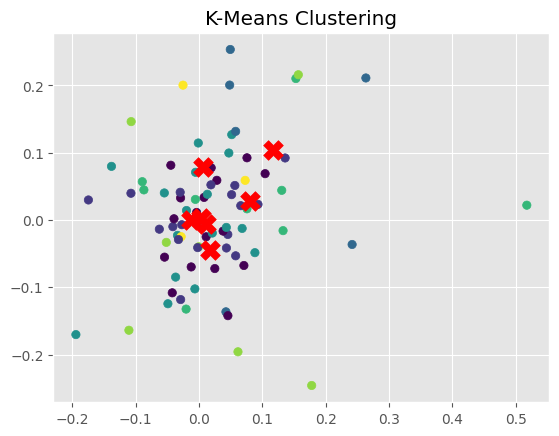

In [410]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
n_components = 7

# Кластеризация
kmeans = KMeans(n_clusters=n_components, random_state=42)
clusters = kmeans.fit_predict(ardl_df_inner_1.T)

silhouette = silhouette_score(ardl_df_inner_1.T, clusters)
calinski = calinski_harabasz_score(ardl_df_inner_1.T, clusters)
davies = davies_bouldin_score(ardl_df_inner_1.T, clusters)

print(f"Silhouette Score: {silhouette:.2f}")
print(f"Calinski-Harabasz Index: {calinski:.2f}")
print(f"Davies-Bouldin Index: {davies:.2f}")
# Визуализация (для 2D)
plt.scatter(ardl_df_inner_1.T.iloc[:, 10],ardl_df_inner_1.T.iloc[:, 13], c=clusters, cmap="viridis")
plt.scatter(kmeans.cluster_centers_[:, 10], kmeans.cluster_centers_[:, 13], s=200, c="red", marker="X")
plt.title("K-Means Clustering")
plt.show()

ValueError: 'c' argument has 17 elements, which is inconsistent with 'x' and 'y' with size 78.

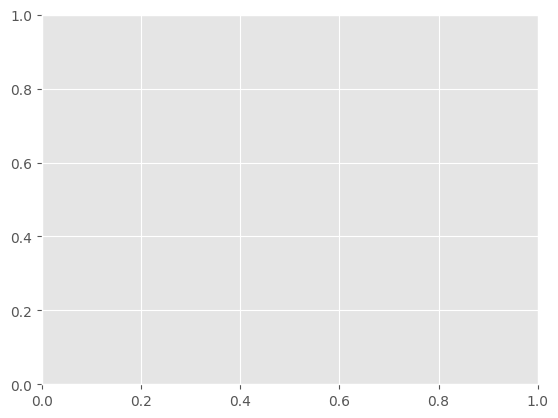

In [411]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(ardl_df_inner_1)
clusters = gmm.predict(ardl_df_inner_1)

plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap="viridis")
plt.title("GMM Clustering")
plt.show()

## XGBoost


### Без сглаживания шоков без PCA


Mean Squared Error: 0.0314
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


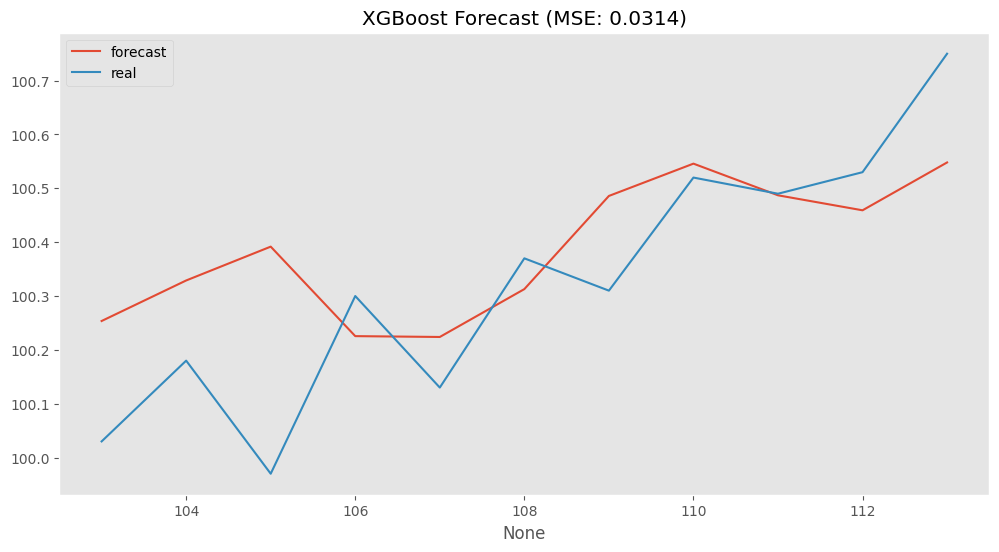

In [16]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()


def create_features(df, target_col='inflation', n_lags=3, window_size=3):
    # 1. Авторегрессионные компоненты (лаги)
    for lag in range(1, n_lags+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    # 2. Скользящие статистики
    df['rolling_mean'] = df[target_col].rolling(
        window=window_size).mean().shift(1)
    df['rolling_std'] = df[target_col].rolling(
        window=window_size).std().shift(1)
    # 3. Временные фичи из даты
    df['month'] = df['ds'].dt.month
    df['quarter'] = df['ds'].dt.quarter
    df['year'] = df['ds'].dt.year
    df['days_in_month'] = df['ds'].dt.days_in_month
    # 4. Дополнительные преобразования
    df['time_idx'] = (df['ds'] - df['ds'].min()).dt.days

    return df.dropna()


# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)

# Разделяем на X и y
X_train_infl = train_feats.drop(
    columns=['inflation', 'ds'], axis=1).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds'], axis=1).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### Без сглаживания шоков с PCA


Mean Squared Error: 0.0363
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


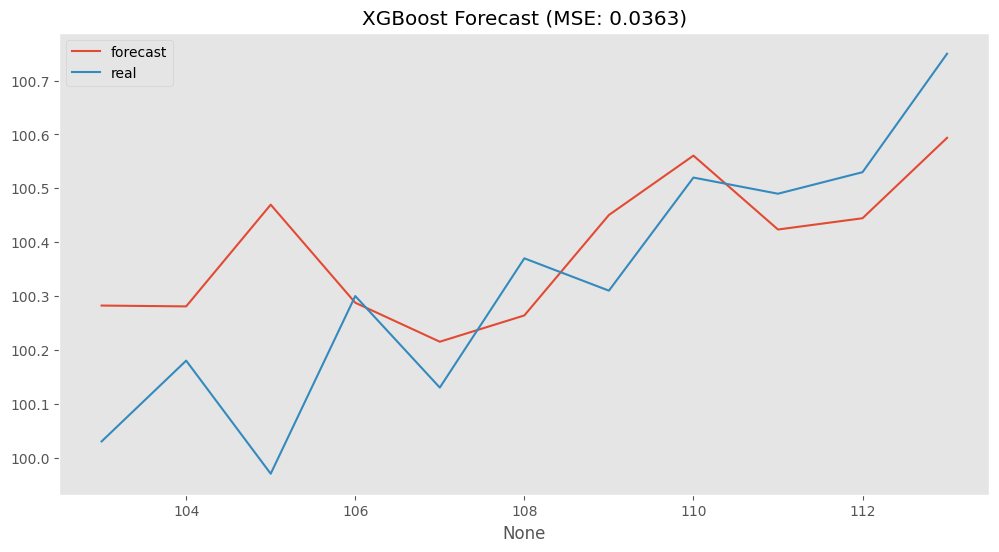

In [17]:
# Дата, которая разделяет тренировочную и тестовую выборки, чтобы делить выборки для всех моделей
train_test_split_date = '2022-05-01'

# импортируем данные и делим их по дате
df = pd.read_csv('final_regional_df/infl_Российская_Федерация.csv')
df['date'] = pd.date_range(start='2014-01-01', periods=len(df), freq='ME')
df.drop(['unemp', 'paid_services'], axis=1, inplace=True)

df_train = df[df['date'] < train_test_split_date].copy()
df_test = df[df['date'] >= train_test_split_date].copy()

# Делим Датафреймы на эндогенные и экзогенные переменные
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

dummies_train = pd.DataFrame(0, index=y_train.index, columns=[
                             'outlier_12', 'outlier_98'])
dummies_test = pd.DataFrame(0, index=y_test.index, columns=[
                            'outlier_12', 'outlier_98'])
dummies_train.iloc[12, 0] = 1  # Дамми для индекса 12
dummies_train.iloc[98, 1] = 1  # Дамми для индекса 98

# Добавляем дамми-переменные к экзогенным факторам
X_train = pd.concat([X_train, dummies_train], axis=1)
X_test = pd.concat([X_test, dummies_test], axis=1)

# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))

# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)


# Разделяем на X и y
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)
y_train = train_feats['inflation']

X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
y_test = test_feats['inflation']

# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)

# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков без PCA


Mean Squared Error: 0.0264
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


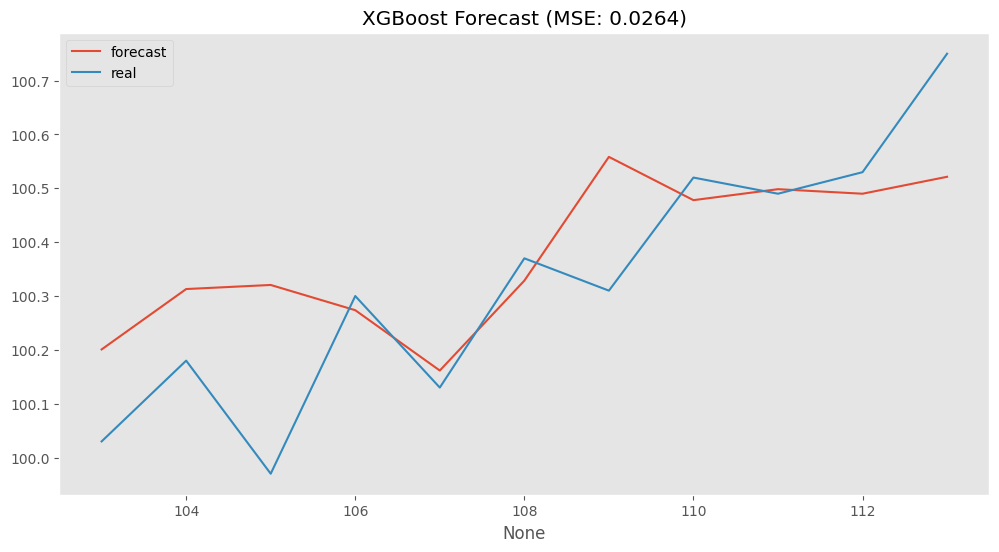

In [18]:
df_1 = df.drop(['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4',	'PCA_5',
               'PCA_6', 'PCA_7', 'PCA_8'], axis=1, inplace=False)
df_train = df_1[df_1['date'] < train_test_split_date].copy()
df_test = df_1[df_1['date'] >= train_test_split_date].copy()
y_train = df_train['inflation']
y_test = df_test['inflation']
df_train.drop(['inflation', 'date'], axis=1, inplace=True)
df_test.drop(['inflation', 'date'], axis=1, inplace=True)
X_train = df_train.copy()
X_test = df_test.copy()

# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()

### С сглаживанием шоков с PCA


/var/folders/r7/t8m59hld1hb_kbs6vxdb07vm0000gn/T/ipykernel_44588/2554253586.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[98] = (y_train[97] + y_train[99]) / 2


Mean Squared Error: 0.0150
Best params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


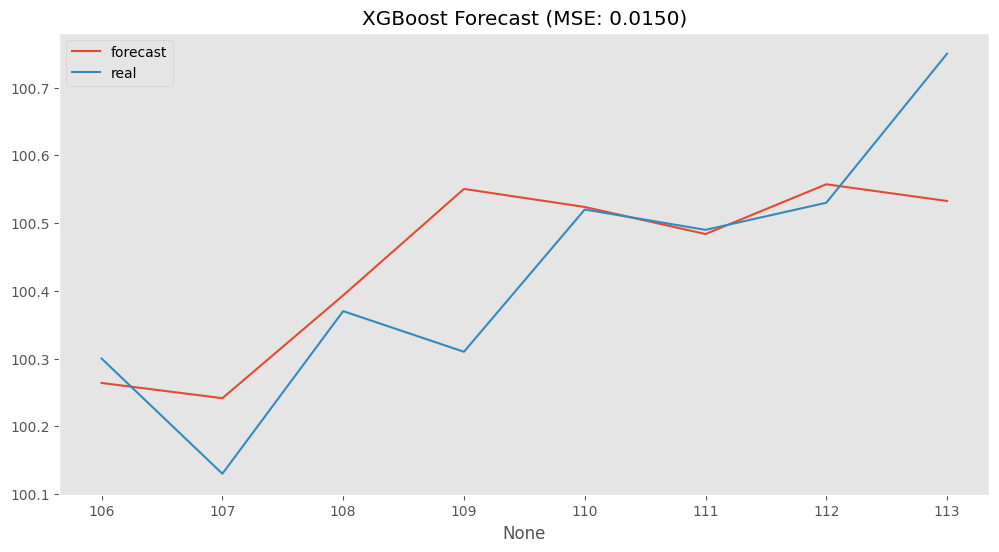

In [19]:
# СДЕЛАЛ УСРЕДНЕНИЕ ШОКОВ
y_train[12] = (y_train[11] + y_train[13]) / 2
y_train[98] = (y_train[97] + y_train[99]) / 2
# Загрузка данных
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

y_train['ds'] = pd.date_range(
    start='2014-01-01', freq='ME', periods=len(y_train))
y_test['ds'] = pd.date_range(end='2023-08-31', freq='ME', periods=len(y_test))
# Создаем фичи для train и test
train_feats = create_features(y_train)
test_feats = create_features(y_test)
# Разделяем на X и y
y_train = train_feats['inflation']
X_train_infl = train_feats.drop(columns=['inflation', 'ds']).join(X_train)

y_test = test_feats['inflation']
X_test_infl = test_feats.drop(columns=['inflation', 'ds']).join(X_test)
# Настройка кросс-валидации для временных рядов
tscv = TimeSeriesSplit(n_splits=3)
# Параметры для подбора
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
# Инициализация и обучение модели
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid_search = GridSearchCV(
    xgb_model, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train_infl, y_train)
# Предсказание
xgb_pred = grid_search.predict(X_test_infl)
# Оценка качества
mse = mean_squared_error(y_test, xgb_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Best params: {grid_search.best_params_}")

# Визуализация
plt.figure(figsize=(12, 6))
sb.lineplot(x=y_test.index, y=xgb_pred, label='forecast')
y_test.plot(label='real')
plt.title(f"XGBoost Forecast (MSE: {mse:.4f})")
plt.legend()
plt.grid()
plt.show()